In [2]:
import numpy as np
import pandas as pd
import zipfile

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from matplotlib import dates,cm
import seaborn as sns
import math

from bisect import bisect_left
from bokeh.plotting import figure,show,output_notebook
from datetime import datetime
import xgboost as xgb
from bokeh.models import Range1d
from datetime import date

from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn import grid_search
from sklearn import cross_validation, metrics as mtrcs
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.kernel_approximation import RBFSampler,Nystroem
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA

from sklearn.svm import SVC

import holidays


output_notebook()
%matplotlib inline

BokehJS successfully loaded.

# 1. Import Data

In [3]:
ztrain = zipfile.ZipFile('Data/train.csv.zip')
ztest = zipfile.ZipFile('Data/test.csv.zip')

train = pd.read_csv(ztrain.open('train.csv'))
test = pd.read_csv(ztest.open('test.csv'))


In [4]:
train.info()
train.tail(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29118021 entries, 0 to 29118020
Data columns (total 6 columns):
row_id      int64
x           float64
y           float64
accuracy    int64
time        int64
place_id    int64
dtypes: float64(2), int64(4)
memory usage: 1.5 GB


,row_id,x,y,accuracy,time,place_id
29118016,29118016,6.5133,1.1435,67,399740,8671361106
29118017,29118017,5.9186,4.4134,67,125480,9077887898
29118018,29118018,2.9993,6.3680,67,737758,2838334300
29118019,29118019,4.0637,8.0061,70,764975,1007355847
29118020,29118020,7.4523,2.0871,17,102842,7028698129


In [5]:
test.info()
test.tail(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8607230 entries, 0 to 8607229
Data columns (total 5 columns):
row_id      int64
x           float64
y           float64
accuracy    int64
time        int64
dtypes: float64(2), int64(3)
memory usage: 394.0 MB


,row_id,x,y,accuracy,time
8607225,8607225,4.1206,5.2443,58,882527
8607226,8607226,5.1170,5.7695,60,984517
8607227,8607227,6.6409,8.3626,19,814024
8607228,8607228,6.4190,2.9985,68,862916
8607229,8607229,8.1017,7.8736,1,845096


In [6]:
train.loc[:,'row_id'] = train.row_id + 8607230

train = train.set_index('row_id',drop=True)
test = test.set_index('row_id',drop=True)

train_index = train.index.values
test_index = test.index.values

concat_all = pd.concat([train.drop('place_id',axis=1),test],ignore_index=0)
concat_all.info()
concat_all.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37725251 entries, 8607230 to 8607229
Data columns (total 4 columns):
x           float64
y           float64
accuracy    int64
time        int64
dtypes: float64(2), int64(2)
memory usage: 1.4 GB


,x,y,accuracy,time
row_id,,,,
8607230,0.7941,9.0809,54,470702
8607231,5.9567,4.7968,13,186555
8607232,8.3078,7.0407,74,322648
8607233,7.3665,2.5165,65,704587
8607234,4.0961,1.1307,31,472130


In [7]:
train.head()

,x,y,accuracy,time,place_id
row_id,,,,,
8607230,0.7941,9.0809,54,470702,8523065625
8607231,5.9567,4.7968,13,186555,1757726713
8607232,8.3078,7.0407,74,322648,1137537235
8607233,7.3665,2.5165,65,704587,6567393236
8607234,4.0961,1.1307,31,472130,7440663949


# 2. Data Preparation

### Check for incorrect values

In [8]:
concat_all.describe().T

,count,mean,std,min,25%,50%,75%,max
x,37725251,4.997864,2.859615,0,2.5307,5.0043,7.4619,10
y,37725251,5.002930,2.887365,0,2.4980,4.9913,7.5091,10
accuracy,37725251,85.085724,117.068909,1,31.0000,63.0000,76.0000,1033
time,37725251,525031.419921,285782.848674,1,288318.0000,550799.0000,768783.0000,1006589


In [9]:
concat_all.accuracy.quantile(0.25)

31.0

In [10]:
# Any null values?

concat_all.isnull().values.any()

False

In [11]:
#train[train.x == 0]

### Variable Distributions

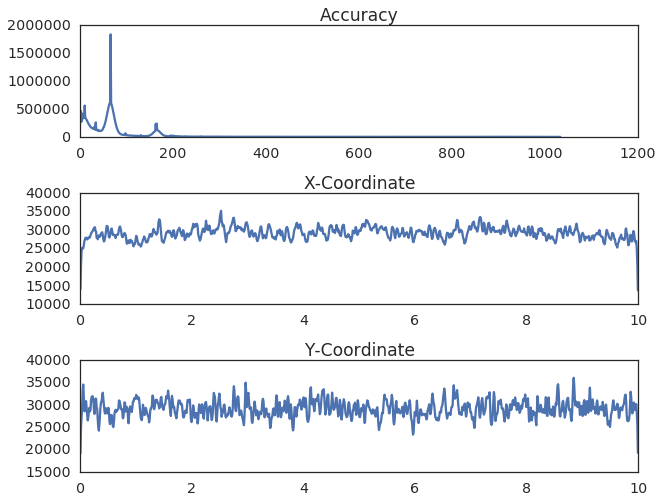

In [12]:
sns.set_style("white")
sns.set_context("talk",font_scale=1.1)

fig = plt.figure(figsize=(10, 8))
fig.subplots_adjust(hspace=.5)

ax1 = fig.add_subplot(3,1,1)
ax1.set_title('Accuracy')

y,binEdges=np.histogram(train['accuracy'],bins=1000)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])

ax1.plot(bincenters,y,'-')

ax2 = fig.add_subplot(3,1,2)
ax2.set_title('X-Coordinate')

y,binEdges=np.histogram(train['x'],bins=1000)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])

ax2.plot(bincenters,y,'-')

ax3 = fig.add_subplot(3,1,3)
ax3.set_title('Y-Coordinate')

y,binEdges=np.histogram(train['y'],bins=1000)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])

ax3.plot(bincenters,y,'-')


# move to for-loop

### Scatter plots of Accuracy

Map most popular place_id's (low and high accuracy)

Determine relationship between accuracy and location

In [13]:
# 25th and 75th percentiles for accuracy in train set

low_acc_quantile = train.accuracy.quantile(0.25)
high_acc_quantile = train.accuracy.quantile(0.75)

print 'low accuracy',low_acc_quantile
print 'high accuracy',high_acc_quantile

low_accuracy = train[train.accuracy < low_acc_quantile]
high_accuracy = train[train.accuracy > high_acc_quantile]



low accuracy 27.0
high accuracy 75.0


In [14]:
top5 = train.place_id.value_counts().index[:5]
train.place_id.value_counts()[:20]

8772469670    1849
1623394281    1802
1308450003    1757
4823777529    1738
9586338177    1718
9129780742    1716
9544215131    1702
5351837004    1699
4638096372    1699
8610202964    1693
6051554924    1689
7363774279    1689
8607353836    1686
8336299754    1683
5204012807    1680
7230349735    1676
7985287621    1673
4371034975    1673
4993591840    1672
7348940462    1670
Name: place_id, dtype: int64

In [15]:
top20_df = train[train.place_id==8772469670]
l_quantile = top20_df.accuracy.quantile(0.25)
h_quantile = top20_df.accuracy.quantile(0.75)

print l_quantile,h_quantile

high_low_df = top20_df[(top20_df.accuracy <= l_quantile) | (top20_df.accuracy >= h_quantile)]
high_low_df.head()

37.0 70.0


,x,y,accuracy,time,place_id
row_id,,,,,
8612564,2.9861,8.2907,77,476201,8772469670
8614102,2.9050,8.2944,466,524560,8772469670
8615861,2.7912,8.2936,36,322627,8772469670
8617390,2.9525,8.2706,27,104329,8772469670
8634959,2.8837,8.2839,22,487252,8772469670


In [26]:
train.place_id.value_counts().index[:5]

Int64Index([8772469670, 1623394281, 1308450003, 4823777529, 9586338177], dtype='int64')

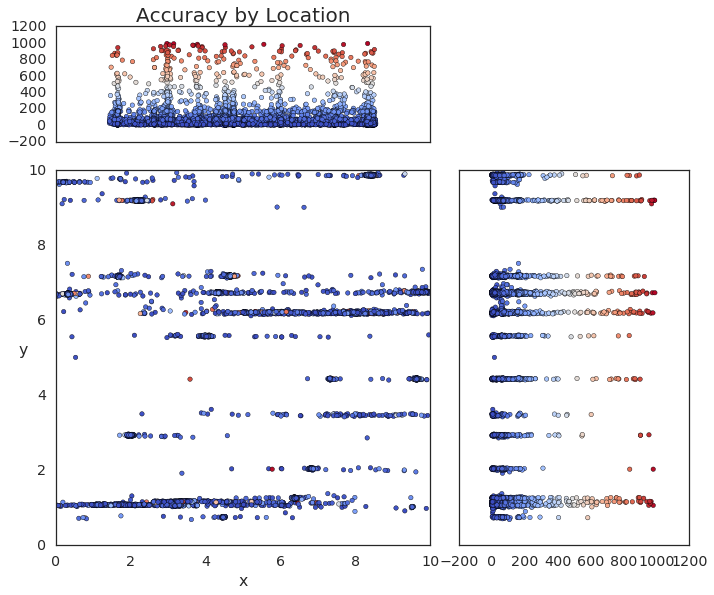

In [16]:
# scatter plot with colorbar showing accuracy

# top 5 most popular place_id's
#top5 = train.place_id.value_counts().index[:5]
top5 = train.place_id.sample(20)

top20_df = train[train.place_id.isin(top5)]

high_low_df = top20_df

nullfmt = NullFormatter() # no labels

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.05

rect_scatter = [left, bottom, width, height]
rect_accx = [left, bottom_h, width, 0.2]
rect_accy = [left_h, bottom, 0.4, height]

fig = plt.figure(1,figsize=(8, 8))

axScatter = plt.axes(rect_scatter)
axAccx = plt.axes(rect_accx)
axAccy = plt.axes(rect_accy)

# scatter plot
axScatter.scatter(high_low_df.x,high_low_df.y, c=high_low_df.accuracy, cmap=plt.cm.coolwarm)

# no labels
axAccx.xaxis.set_major_formatter(nullfmt)
axAccy.yaxis.set_major_formatter(nullfmt)

# accuracy plots

axAccx.scatter(high_low_df.x,high_low_df.accuracy,c=high_low_df.accuracy, cmap=plt.cm.coolwarm)
axAccy.scatter(high_low_df.accuracy,high_low_df.y,c=high_low_df.accuracy, cmap=plt.cm.coolwarm)

axScatter.set_ylim([0,10])
axScatter.set_xlim([0,10])
axAccy.set_ylim([0,10])
axAccx.set_title('Accuracy by Location',fontsize=20)
axScatter.set_xlabel('x')
axScatter.set_ylabel('y',rotation=0)

plt.show()


After plotting accuracy with x and y for a few place_id's, I'm going to guess that Accuracy has more of an effect on X than Y. Let's show this with the data:

In [17]:
top = train.place_id.value_counts().index[:100000]

top_df = train[train.place_id.isin(top)].groupby('place_id').std()

print 'X std. dev. by place_id',top_df.x.mean()
print 'Y std. dev. by place_id',top_df.y.mean()

X std. dev. by place_id 0.654677499905
Y std. dev. by place_id 0.0198296091828


In [18]:
#top20_df.quantile(0.90)

In [34]:
place_id_count = train[['place_id','x']].groupby('place_id').count()
place_id_count.sort_values('x',ascending=True)

,x
place_id,
5964251556,1
4741604432,1
9602765305,1
5369696092,1
8402352480,1
5714851113,1
2840036477,1
9091399268,1
3507798159,1


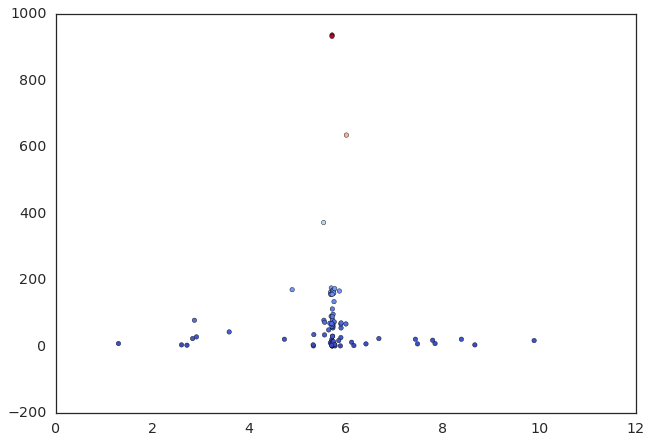

In [31]:
# plot X and accuracy
#top5 = train.place_id.value_counts().index[:5]
#top5 = train.place_id.sample(20)

#top20_df = train[train.place_id.isin(top5)]
top20_df_ = train[train.place_id==3107193884]


#top20_df_ = top20_df[top20_df.accuracy > 139]

plt.scatter(top20_df_.x, top20_df_.accuracy, c=top20_df_.accuracy,cmap=plt.cm.coolwarm)
plt.show()

### Calculate Accurate X

Given X and Y, can we calculate accurate X^ for each place_id?

In [19]:
accuracy_90q = train[['accuracy','place_id']].groupby('place_id').quantile(0.95)
accuracy_90q = accuracy_90q.loc[:,'accuracy']

In [34]:
accuracy_90q.head()

place_id
1000015801    224.2
1000017288    170.6
1000025138    173.9
1000052096    177.0
1000063498    705.7
Name: accuracy, dtype: float64

In [ ]:
# get 90% accuracy threshold for each place_id and determine average X and Y for each place_id

In [29]:
accuracy_90q.ix[1000213704]

278.79999999999944

In [ ]:
#test on one place_id!

In [37]:
one_pid = train[train['place_id'] == 1000017288]

one_pid[one_pid.accuracy>=170.6].groupby('place_id').std()

#one_pid.groupby('place_id').std()

,x,y,accuracy,time
place_id,,,,
1000017288,0.393731,0.013423,95.507591,237812.202523


In [21]:
#one_pid = train[train['place_id'] == 1000213704]

#train_90_acc = one_pid[one_pid['accuracy'] >= accuracy_90q.ix[one_pid.place_id]]
train_90_acc = train[train['accuracy'] >= accuracy_90q.ix[train.place_id]]

#train_90_acc[train_90_acc.place_id==8523045610].describe()

train_90_acc.head()

,x,y,accuracy,time,place_id
row_id,,,,,
8607269,1.2191,1.3462,743,477469,6171384989
8607297,0.2758,6.2541,182,636948,6318874027
8607313,4.9941,0.0960,177,140586,6040906104
8607340,4.2822,4.4936,483,358235,8855290574
8607381,5.7475,4.4212,415,444839,4435641053


Once you have accurate X and Y for all place_id's, how do we get to an accurate X for
each user based on accuracy (and maaaybe time)? 


In [22]:
train_90_acc[train_90_acc.place_id==1000213704].describe()

#train_90_acc.isnull().values.any()

,x,y,accuracy,time,place_id
count,9.000000,9.000000,9.000000,9.000000,9
mean,2.049400,0.812800,540.111111,661976.777778,1000213704
std,1.071796,0.086416,239.602506,79442.567385,0
min,0.284600,0.583700,318.000000,596795.000000,1000213704
25%,1.148600,0.838800,342.000000,598403.000000,1000213704
50%,2.483000,0.840200,459.000000,600577.000000,1000213704
75%,2.719300,0.850000,750.000000,725149.000000,1000213704
max,3.430800,0.851400,974.000000,784173.000000,1000213704


In [47]:
train_90_acc.groupby('place_id').mean()

,x,y,accuracy,time
place_id,,,,
1000015801,2.701412,5.553050,312.750000,293338.375000
1000017288,7.494010,4.345820,194.200000,314102.600000
1000025138,0.989400,5.571485,253.830508,365622.644068
1000052096,2.908781,5.832147,264.123711,426805.391753
1000063498,5.007033,7.544333,662.833333,601640.500000
1000213704,2.422833,0.828911,384.166667,629697.333333
1000383269,2.139833,2.931222,566.000000,678104.111111
1000392527,1.577279,3.254964,264.142857,519549.500000
1000472949,6.494978,0.947711,412.777778,404226.333333


# 3. Feature Engineering

### Time features

In [ ]:
# hour
# day
# year
# weekday
# weekend
# night_time
# season

### Coordinate Features

In [ ]:
# cartesian coordinates
# rotated coordinates

# 4.  Model Building

In [ ]:
# create MAP@3 function for grid search
# https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py

def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=3):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])